In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Init

In [3]:
# path = 'C:/Users/robin.opdam/Google Drive/Thesis (Msc)/Thesis_shared_files/'
path = '/Users/Robin/Google Drive/Thesis (Msc)/Thesis_shared_files/'

---
# Compare Results

In [13]:
def read_cfrnn(file_name):
    df = pd.read_pickle(path + 'Logs/final/' + file_name + '_cfrnn_log')
    df = df.rename({'loss':'train_loss'}, axis=1)
    return df

In [14]:
def read_neumf(file_name):
    df = pd.read_pickle(path + 'Logs/final/' + file_name + '_neumf_log')
    df['train_loss'] = [l['loss'] for l in df.NeuMF]
    return df

In [15]:
def read_bpr(file_name):
    return pd.read_pickle(path + 'Logs/final/' + file_name + '_bpr_log')

In [16]:
file_names = ['am_20k_users', 'ml_1m', 'am_like_ml']

In [17]:
df = read_neumf(file_names[1])
print(df.iloc[0].sample_size, df.iloc[0].sample_size + df.iloc[0].sample_size*read_neumf('am_20k_users').iloc[0].num_neg)

998709 4993545


## All metrics comparison

In [18]:
from Evaluation import get_final_results
from visualize_results import plot_final_metrics

final_results = {}
labels = ['BPR', 'NeuMF', 'CFRNN']
colors = ['blue', 'red', 'green']
metrics_to_show = ['recall', 'ndcg']
y_labels = ['Recall', 'NDCG']
titles = ['', '', '']
read_funcs = [read_bpr, read_neumf, read_cfrnn]

for label, read_func in zip(labels, read_funcs):
    final_results[label] = {}
    final_results[label]['metrics'] = {}
    final_results[label]['stats'] = {}
    final_results[label]['time'] = {}
    
    for file_name, title in zip(file_names, titles):
        res = read_func(file_name)
        final_metrics, train_stats, train_time = get_final_results(res)
        final_results[label]['metrics'][file_name] = final_metrics
        final_results[label]['stats'][file_name] = train_stats
        final_results[label]['time'][file_name] = train_time

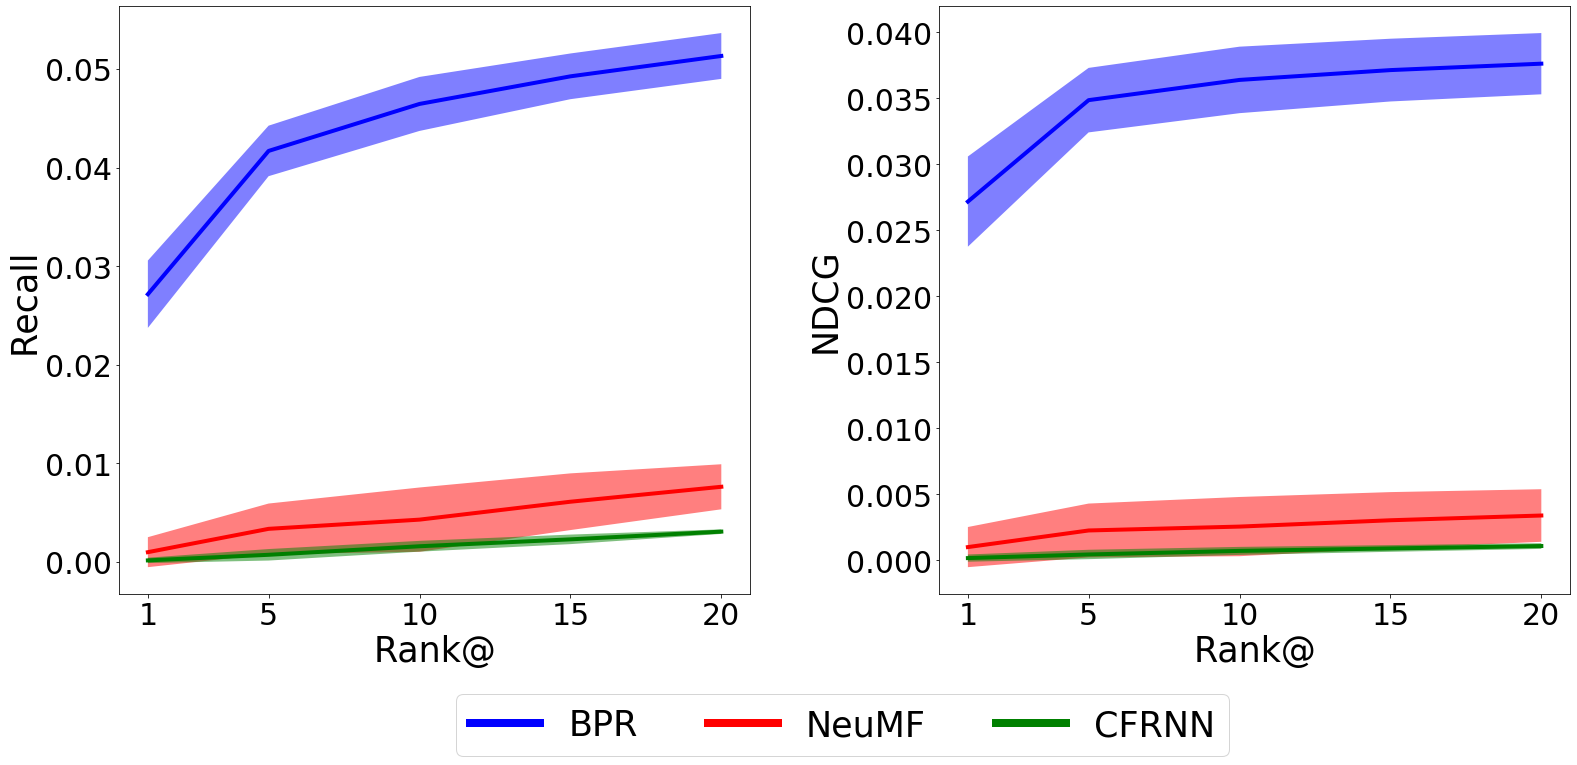

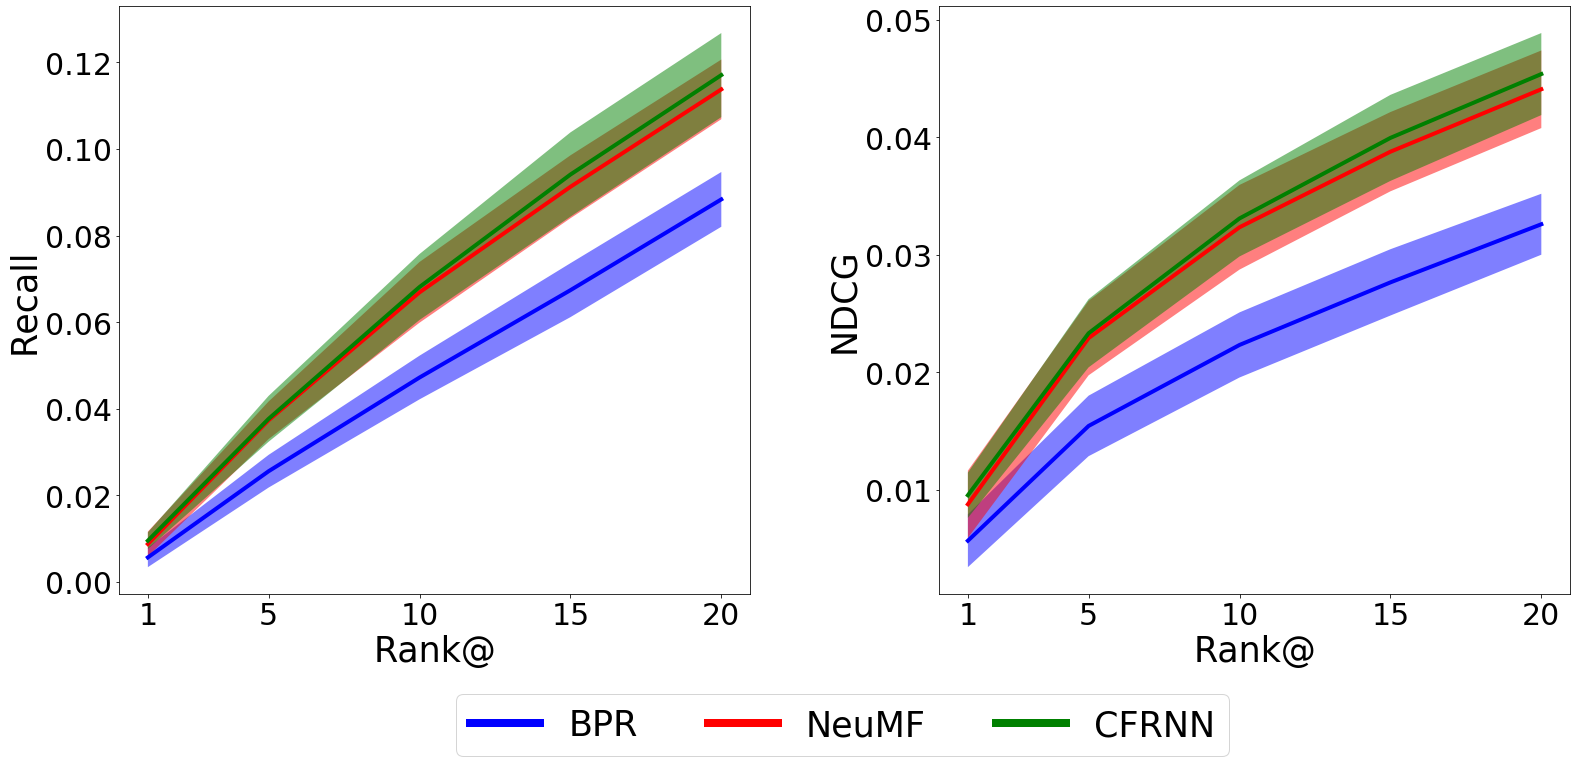

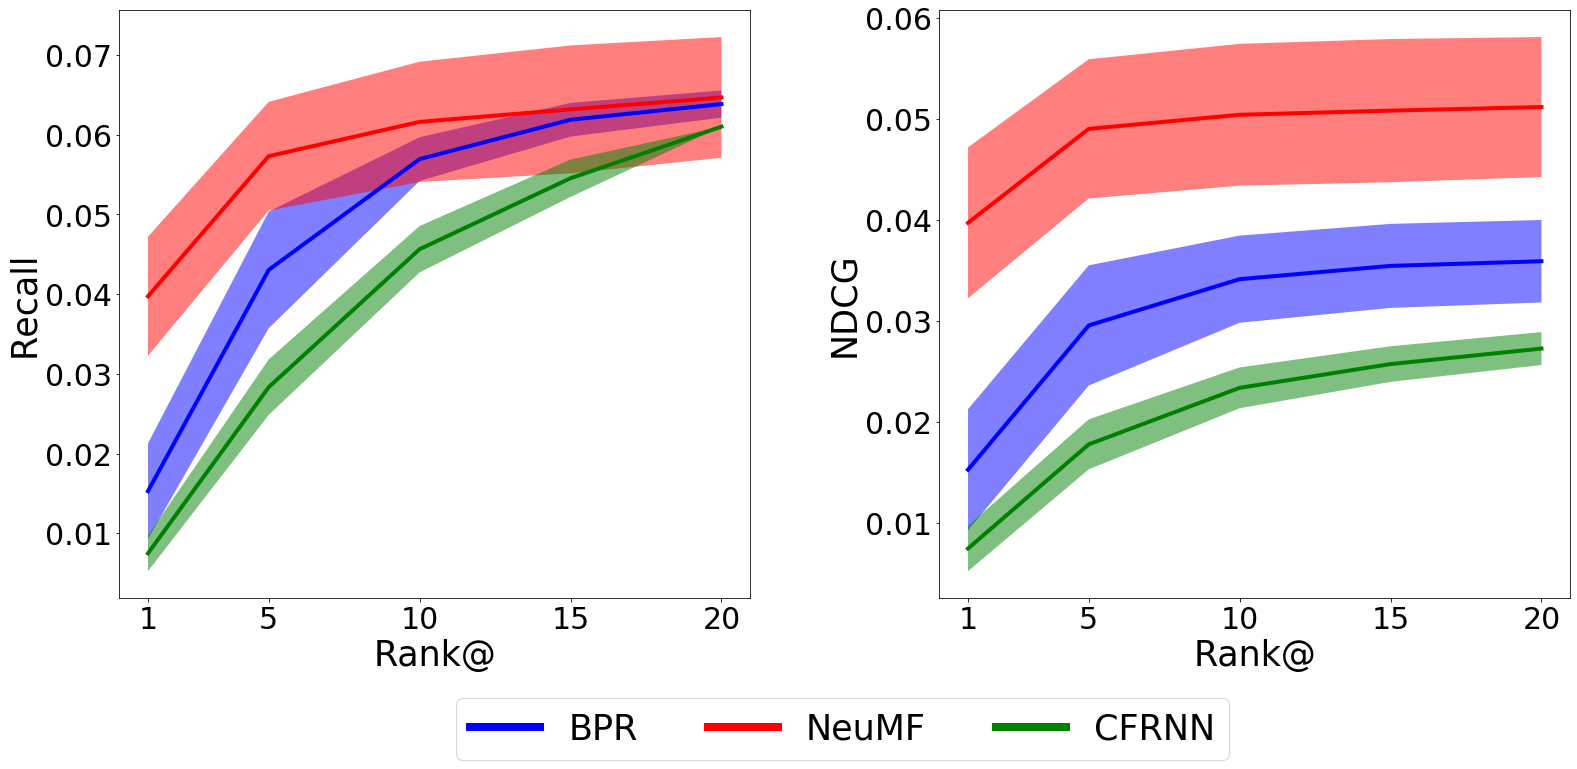

In [23]:
legends = [True, True, True]
for file_name, title, legend in zip(file_names, titles, legends):
    plot_final_metrics(final_results, file_name, colors, metrics_to_show, y_labels, title, store_path=path + 'Plots/Comparison/' + file_name, show_legend=legend)

## Stats

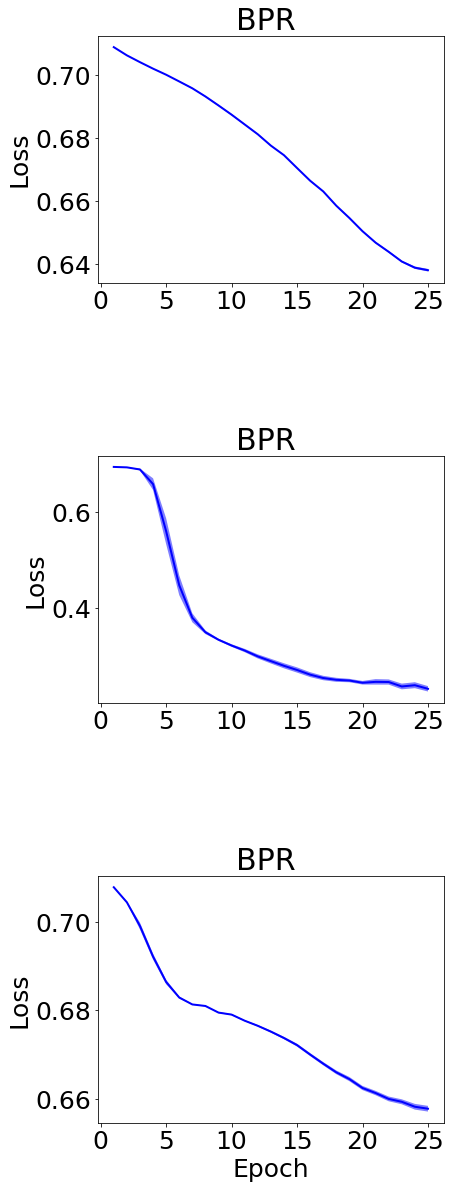

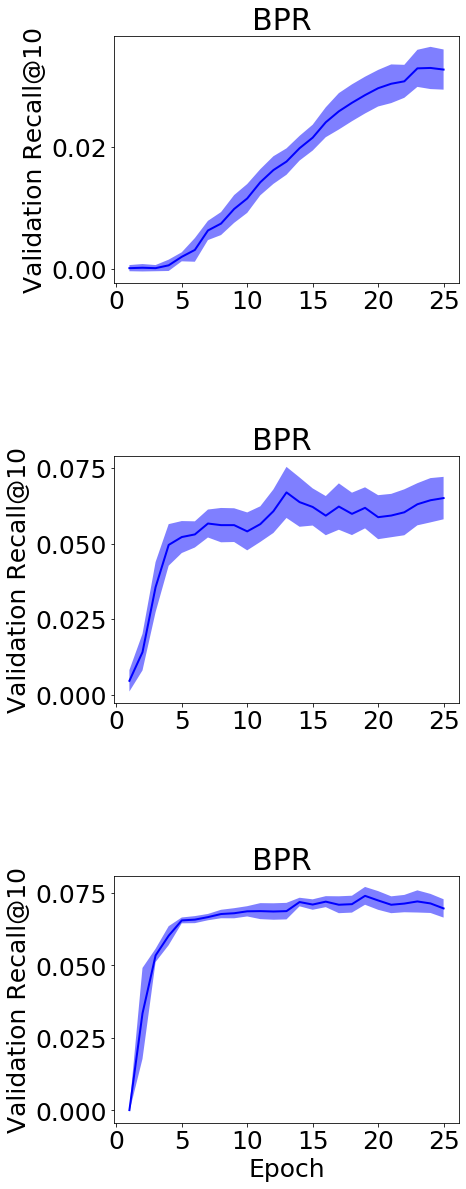

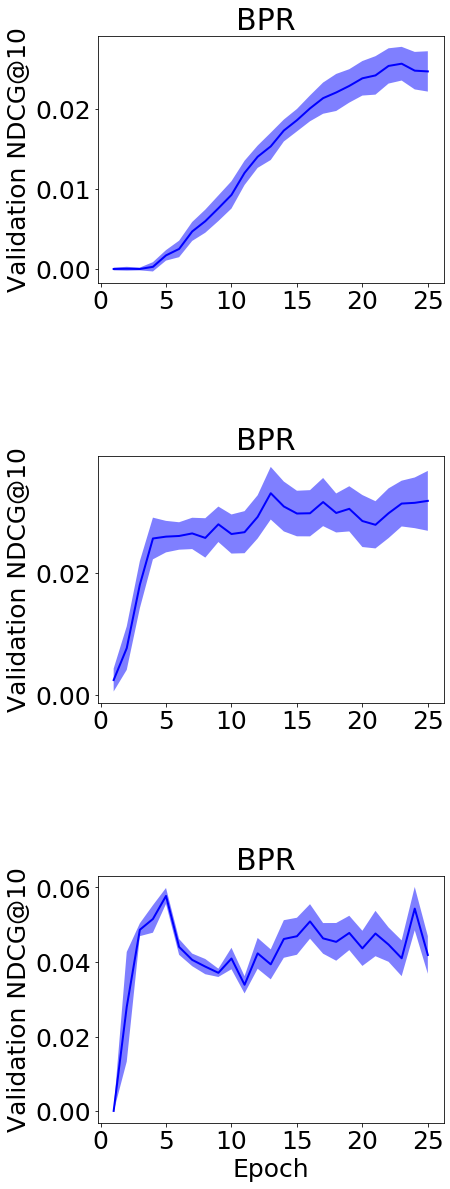

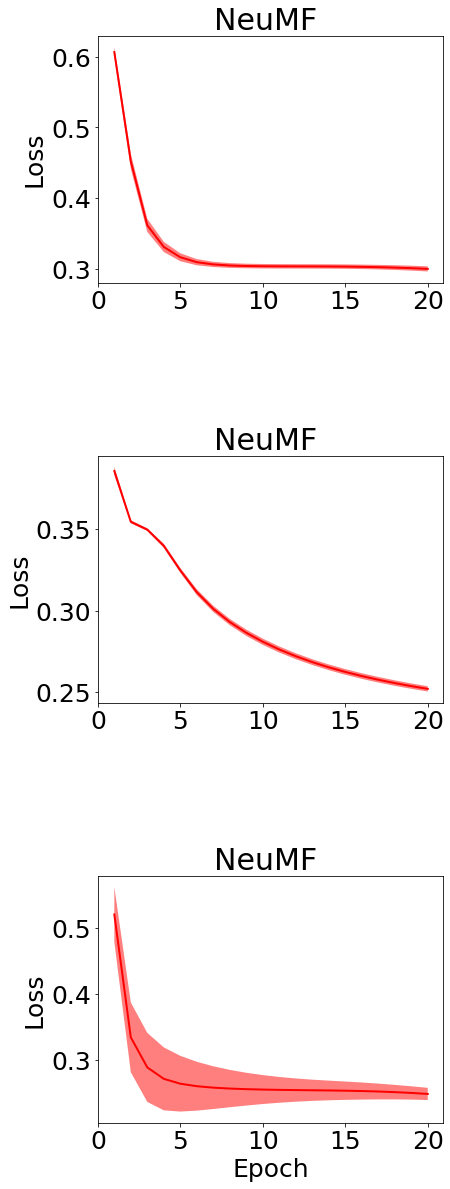

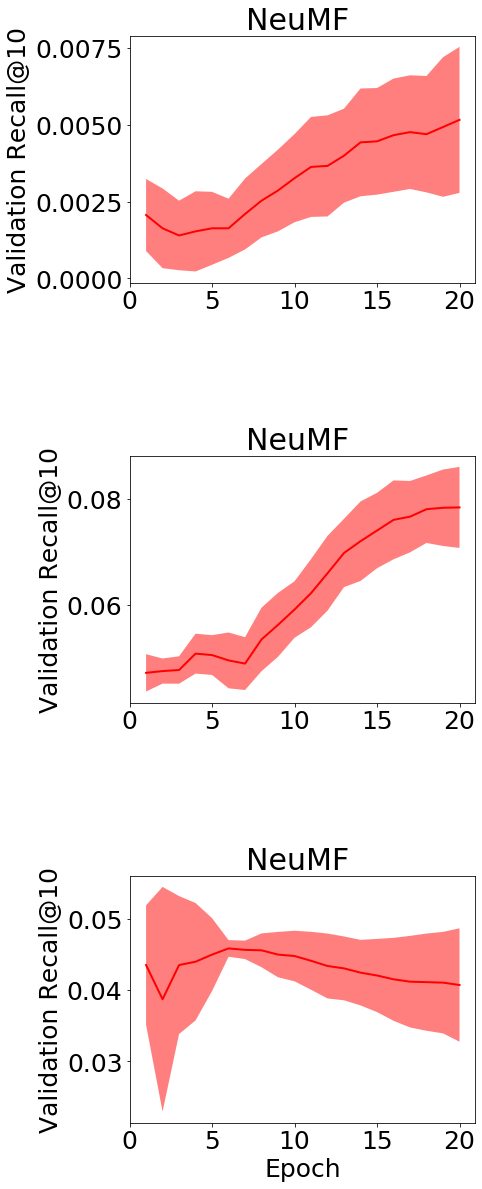

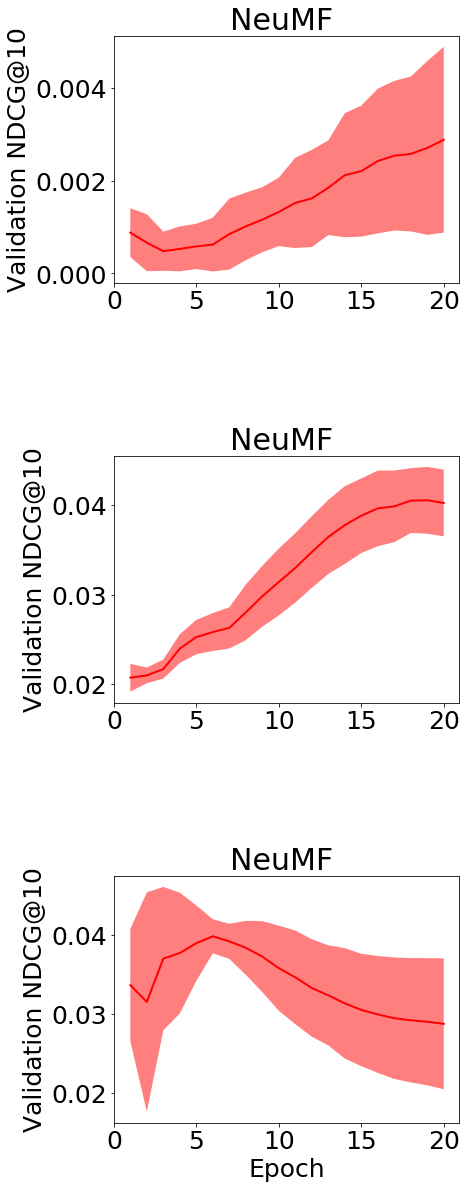

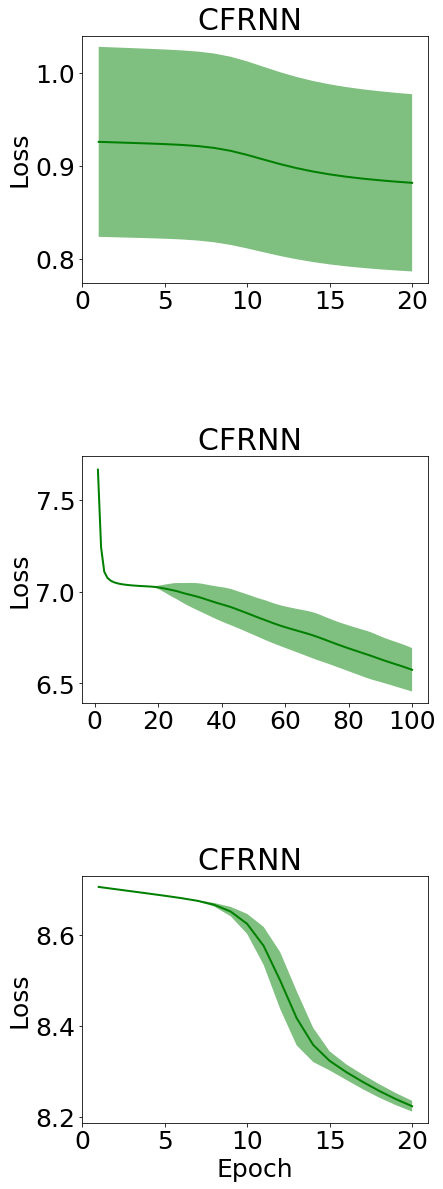

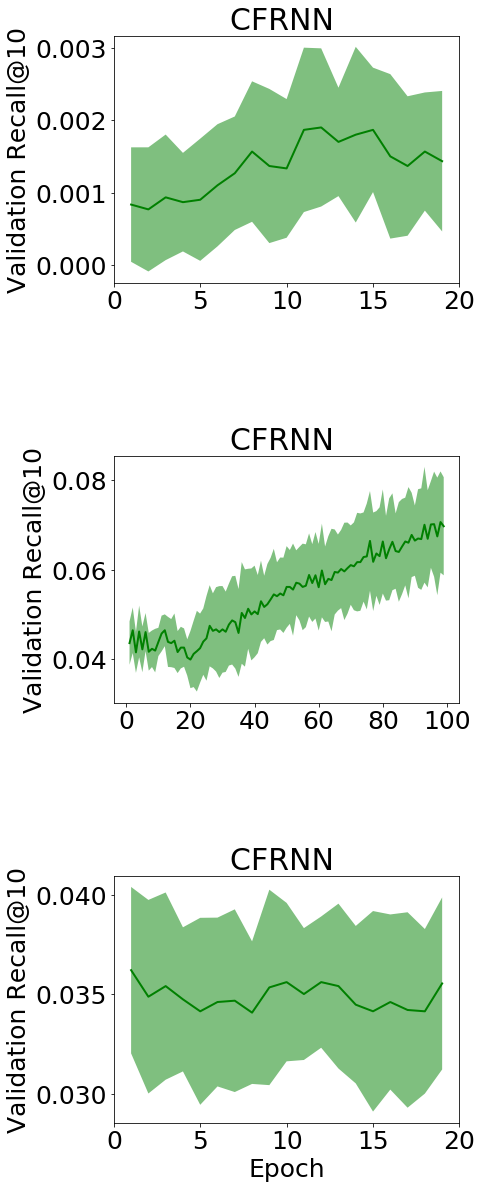

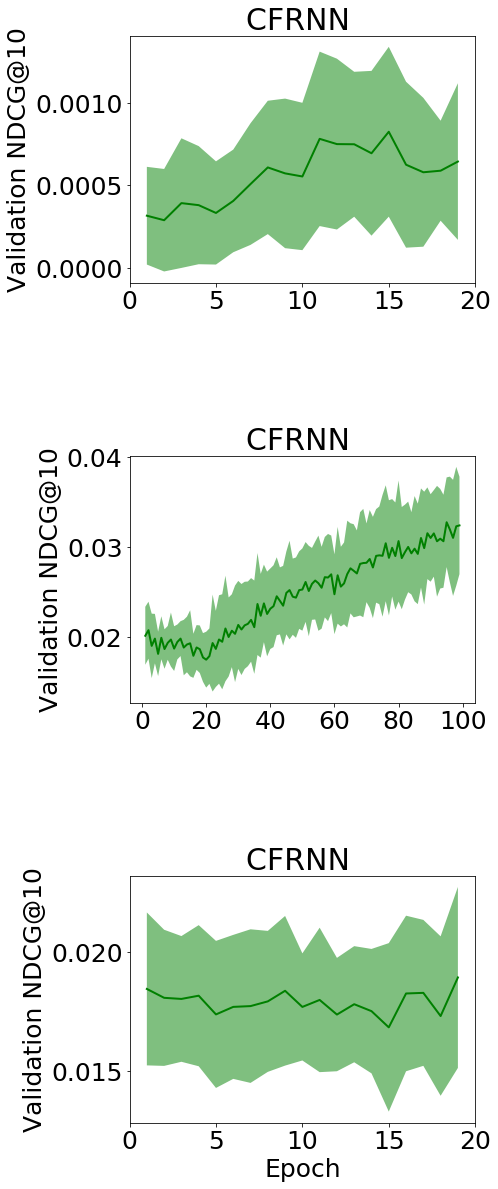

In [21]:
from visualize_results import plot_train_stat
stats = ['loss', 'val_rec@10', 'val_ndcg@10']
ylabels = ['Loss', 'Validation Recall@10', 'Validation NDCG@10']
store_path = path + 'Plots/' 

for label, color in zip(labels, colors):
    for stat, ylabel in zip(stats, ylabels):
        plot_train_stat(final_results=final_results, 
                        stat=stat, 
                        ylabel=ylabel,
                        label=label, 
                        file_names=file_names, 
                        titles=titles, 
                        color=color,
                        store_path= store_path + label + '/' + stat)

## Store Grid Search Results in Excel

In [89]:
def transform(model_name, df):
    if model_name == 'bpr':
        to_keep = ['total_val_rec', 'val_rec@10', 'nolf', 'n_iterations', 'sample_size', 'alpha', 'rho', 'sigma', 'reg_user', 'reg_item']
        df = df[to_keep].copy()
        df = df.rename({'alpha':'learning_rate'}, axis=1)
        return df
        
    if model_name == 'cfrnn':
        to_keep = ['val_rec@10', 'total_val_rec', 'train_time', 'epochs', 'BATCH_SIZE', 'learning_rate', 'delta',
       'max_seq_len', 'embedding_dim', 'rnn_units', 'pad_value']
        return df[to_keep]
        
    to_keep = ['total_val_rec', 'val_rec@10', 
               'train_time', 'learning_rate', 'batch_size', 'layers', 'reg_layers',
               'reg_mf', 'nolf', 'epochs', 'num_neg', 'optimizer']
    
    df = df[to_keep].copy()
#     df['train_loss'] = [l['loss'] for l in df['NeuMF']]
#     df = df.drop(columns='NeuMF')
    
    return df

In [90]:
model_names = ['bpr', 'cfrnn', 'neumf']
writer = pd.ExcelWriter(path + 'Logs/GS/' + 'Grid_Search_top5s.xlsx', engine='xlsxwriter')
for file_name in file_names:
    for model_name in model_names:
        res = pd.read_pickle(path + 'Logs/GS/' + file_name + '_' + model_name + '_gs_log')
        df = transform(model_name, res).sort_values('val_rec@10', ascending=False).iloc[:5]
        df.to_excel(writer, sheet_name=file_name + '_' + model_name)
writer.save()

---
# Statistical Testing

### Get DFs of recalls and ndcgs per file_name and algo

### Store p_values of Wilcoxon and T-test
- paired tests as all models are tested on same underlying test set

In [124]:
def round_string(x):
    strx = str(round(x, 8)) 
    if x < 0.001:
        strx += '***'
    elif x < 0.01:
        strx += '**'
    elif x < 0.05:
        strx += '*'
    return strx

In [125]:
from scipy.stats import ttest_rel, wilcoxon
def store_p_values(file_names, read_funcs, metric, store_path, ranks_at=[1,5,10,15,20], threshold=0.05):
    to_check = ['BPR vs CFRNN', 'BPR vs NEUMF', 'NEUMF vs CFRNN']
    writer = pd.ExcelWriter(store_path + '.xlsx', engine='xlsxwriter')
    for file_name in file_names:
        ps_wil = {}
        ps_t = {}
        for read_func_1 in read_funcs:
            for read_func_2 in read_funcs:
                if read_func_1.__name__ != read_func_2.__name__:
                    name = str.upper(read_func_1.__name__[5:]) + ' vs ' + str.upper(read_func_2.__name__[5:])
                    if name in to_check:
                        ps_wil[name] = []
                        ps_t[name] = []
                        for i, rank_at in enumerate(ranks_at):
                            sample_1 = metric[file_name][read_func_1.__name__[5:]][f'rank_at_{rank_at}']
                            sample_2 = metric[file_name][read_func_2.__name__[5:]][f'rank_at_{rank_at}']
                            stat, p_wil = wilcoxon(sample_1, sample_2)
                            stat, p_t = ttest_rel(sample_1, sample_2)
                            ps_wil[name].append(p_wil)
                            ps_t[name].append(p_t)
        
        df_wil = pd.DataFrame.from_dict(ps_wil)
        df_wil['Rank@'] = ranks_at
        df_wil = df_wil[df_wil.columns[::-1]]
        df_wil = df_wil.applymap(round_string)
        df_wil.to_excel(writer, sheet_name=file_name + '_' + 'wilcox', index=False)

        df_t = pd.DataFrame.from_dict(ps_t)
        df_t['Rank@'] = ranks_at
        df_t = df_t[df_t.columns[::-1]]
        df_t = df_t.applymap(round_string)
        df_t.to_excel(writer, sheet_name=file_name + '_' + 't-test', index=False)

    writer.save()

In [130]:
store_path = path + 'Statistics/p_values_recall'
store_p_values(file_names, read_funcs, recalls, store_path=store_path)

In [131]:
store_path = path + 'Statistics/p_values_ndcg'
store_p_values(file_names, read_funcs, ndcgs, store_path=store_path)

In [84]:
df_t.applymap(round_string)

1.0
5.0
10.0
15.0
20.0
1
5
10
15
20
0.00864651**
2.16e-06***
7.468e-05***
2e-08***
0.0***
0.0***
0.0***
0.0***
0.0***
0.0***
0.0***
0.0***
0.0***
0.0***
0.0***


,Rank@,NEUMF vs CFRNN,BPR vs CFRNN,BPR vs NEUMF
0,1,0.00864651**,0.0***,0.0***
1,5,2.16e-06***,0.0***,0.0***
2,10,7.468e-05***,0.0***,0.0***
3,15,2e-08***,0.0***,0.0***
4,20,0.0***,0.0***,0.0***


In [296]:
a = str.split('BPR vs CFRNN')
b = 'CFRNN vs BPR'
str(a[::-1]) == b

False

In [297]:
str(a[::-1])

"['CFRNN', 'vs', 'BPR']"